# CNN
This notebook contains a test CNN in pytorch, to get familiar with this developping environment. It also acts as a template for later use.

In [1]:
%matplotlib inline
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import os,sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time

#seed for reproducible results
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

## Pytorch module

This module contains the CNN named SimpleCNN.

In "init", the layers have to be initialized (for instance conv layers, maxpool layers and fully connected layers. ReLu do not take hyperparameters, so it doesn't need an initialization.

In "forward", the structure of the CNN is laid out by taking an input tensor x and applying the layers in the correct order to this tensor. This function is the forward pass of the CNN and returns the computed x.

The backward pass can be computed by Pytorch's autograd function. For this to be achieved, our input tensor and our weights must be of type "Variable" (as imported above), this type stores changes to the tensor automatically which makes it possible to compute the gradient very easily. When declaring a Variable tensor, the option "requires_grad" must be set to True, otherwise the gradient will not be computed.

### Module structure

For this example module, we will define a fully convolutional neural network (FCN), with three convolutional layers and one transposed convolution (or deconvolution) to upsample the results of the convolutions.


- Input image: 3 channels 400x400

Three convolutions layers so that spatial stuff happen (every parameter is pretty arbitrary right now)
- Convolution with kernel size 5, reduce to 1 channel (output  1 channel 396x396)
- ReLu
- MaxPool with kernel size 2 (output 198x198)
- Convolution with kernel size 17 (output 182x182)
- ReLu
- MaxPool with kernel size 2 (output 91x91)
- Convolution with kernel size 22 (output 70x70)
- ReLu
- MaxPool with kernel size 2 (output 35x35)

A transposed convolution layer
- Deconv with kernel size 400-35+1=366 (output 400x400)
- Sigmoid for the binary classification

In [3]:
class FCN_3conv_1deconv(torch.nn.Module):
        
    def __init__(self):
        super(FCN_3conv_1deconv, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 1, kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = torch.nn.Conv2d(1, 1, kernel_size=17)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = torch.nn.Conv2d(1, 1, kernel_size=22)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.deconv = torch.nn.ConvTranspose2d(1, 2, kernel_size=366)
        self.sigmoid = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = self.deconv(x)
        x = self.sigmoid(x)
        
        return(x)

This model optimized with adam and cross entropy will converge to all-black images every time

## Training the model

In [4]:
# Loading a set of 100 training images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = np.array([load_image(image_dir + files[i]) for i in range(n)]).swapaxes(1,3).swapaxes(2,3)
print(np.shape(imgs))

train_input = imgs[0:90]
validation_input = imgs[90:100]

image_dir = root_dir + "groundtruth/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(np.shape(imgs))

train_target = imgs[0:90]
validation_target = imgs[90:100]

Loading 100 images
(100, 3, 400, 400)
Loading 100 images
(100, 400, 400)


We will keep 10 images from this set as a validation set

### Instantiate the model, loss function and optimizer

In [5]:
# We will optimize the cross-entropy loss using adam algorithm
net = FCN_3conv_1deconv()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [6]:
def trainNet(net, n_epochs):
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        total_loss = 0.0
        
        for index in range(np.shape(train_input)[0]):
            
            input_image = Variable(torch.tensor(train_input[index], requires_grad=True).unsqueeze(0))
            target_image = Variable(torch.tensor(train_target[index], dtype=torch.long).unsqueeze(0))
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(input_image)
            loss = loss_function(outputs, target_image)
            loss.backward()
            optimizer.step()
            
            #Print statistics
            total_loss += loss.item()
            
            print("Epoch", epoch, ", image", index, ", image loss:", loss.item(), ", time elapsed:", time.time() - training_start_time)
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for index in range(np.shape(validation_input)[0]):
            
            input_image = Variable(torch.tensor(validation_input[index], requires_grad=True).unsqueeze(0))
            target_image = Variable(torch.tensor(validation_target[index], dtype=torch.long).unsqueeze(0))
            
            #Forward pass
            val_outputs = net(input_image)
            val_loss = loss_function(val_outputs, target_image)
            total_val_loss += val_loss.item()
            
        print("Validation loss for epoch", epoch, ":", total_val_loss/np.shape(validation_input)[0])
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [7]:
trainNet(net, 10)

Epoch 0 , image 0 , image loss: 0.693555474281311 , time elapsed: 3.1247904300689697
Epoch 0 , image 1 , image loss: 0.6882050037384033 , time elapsed: 6.273568153381348
Epoch 0 , image 2 , image loss: 0.6805382370948792 , time elapsed: 8.800349235534668
Epoch 0 , image 3 , image loss: 0.6692225337028503 , time elapsed: 11.505416631698608
Epoch 0 , image 4 , image loss: 0.6473919153213501 , time elapsed: 14.258381605148315
Epoch 0 , image 5 , image loss: 0.610875129699707 , time elapsed: 16.722432851791382
Epoch 0 , image 6 , image loss: 0.5732976794242859 , time elapsed: 19.156139373779297
Epoch 0 , image 7 , image loss: 0.5185819268226624 , time elapsed: 21.636812210083008
Epoch 0 , image 8 , image loss: 0.45166683197021484 , time elapsed: 24.150572299957275
Epoch 0 , image 9 , image loss: 0.39871588349342346 , time elapsed: 26.619473695755005
Epoch 0 , image 10 , image loss: 0.37921154499053955 , time elapsed: 29.102211236953735
Epoch 0 , image 11 , image loss: 0.33413729071617126 ,

KeyboardInterrupt: 

In [8]:
input_image = torch.tensor(validation_input[5]).unsqueeze(0)
target_image = torch.tensor(validation_target[5]).unsqueeze(0)
           
#Forward pass
val_output = net(input_image)
output_image = val_output[0,1]

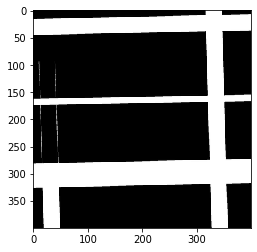

In [9]:
plt.imshow(target_image.squeeze(0), cmap='Greys_r')

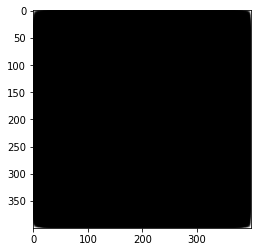

In [10]:
plt.imshow(output_image.detach().numpy(), cmap='Greys_r')